# Fashion-MNIST Classification

 1. Reading the dataset and creating dataloaders
 
 2. Creating the model
      
 3. Creating the loss and optimizer
      
 4. The training script
 
 5. Final model accuracy on Fashion-MNIST Validation Set

In [1]:
# Importing all necessary packages

import my_utils as mu
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from einops import rearrange

## 1. Reading the dataset and creating dataloaders

In reading the dataset I make use of the `load_data_fashion_mnist()` function in `my_utils` to load the dataset into dataloaders.

In [2]:
batch_size = 16
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

## 2. Creating the model

The model is an expansion of the basic MLP. It consists of a stem which takes as input an image from the Fashion-MNIST dataset, and divides this into 4 non-overlapping patches. The resulting tensor is then fed into a linear layer before transposition.

The backbone consists of one blocks containing two sets of two linear layers separated by another transpose.

The classifier consists of an averaging layer followed by a single linear layer, resulting in 10 outputs, matching the 10 classes in the dataset.

In [3]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, image_size, patch_size, vector_dim):
        super(Net, self).__init__()
        assert image_size % patch_size == 0
        num_patches = (image_size // patch_size) ** 2
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.image_size = image_size
        self.patch_size = patch_size
        self.vector_dim = vector_dim
        self.LinearStem = nn.Linear(patch_size ** 2, vector_dim)
        self.Linear1 = nn.Linear(num_patches, num_hidden)
        self.Linear2 = nn.Linear(num_hidden, num_hidden)
        self.Linear3 = nn.Linear(vector_dim, num_hidden)
        self.Classifier = nn.Linear(num_hidden, num_outputs)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        
        # STEM
    
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        x = self.LinearStem(x)
        
        x = torch.transpose(x,1,2)
        
        # BACKBONE
        
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.Linear2(x)
        x = torch.transpose(x,1,2)
        x = self.Linear3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.Linear2(x)
        
        # CLASSIFIER
        
        x = torch.mean(x,1)
        out = self.Classifier(x)
        return out

In [4]:
num_inputs, num_hidden, num_outputs, image_size, patch_size, vector_dim = 784, 256, 10, 28, 14, 128
net = Net(num_inputs, num_hidden, num_outputs, image_size, patch_size, vector_dim)

## 3. Creating the loss and optimizer

In [5]:
loss = nn.CrossEntropyLoss()
lr, wd = 0.1, 0

optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

## 4. The training script

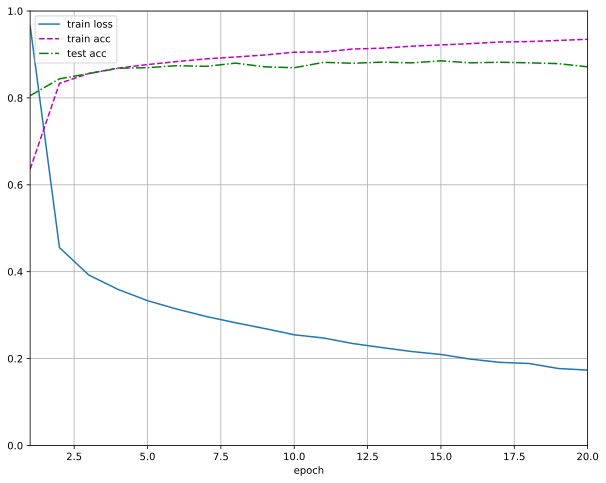

In [6]:
num_epochs = 20
mu.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

## 5. Final model accuracy on Fashion-MNIST Validation Set

In [7]:
mu.evaluate_accuracy(net, test_iter)

0.8715